### Shape 문제 해결 필요

In [1]:
import os
import random
import math
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import deque
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, concatenate, Conv2D, MaxPooling2D
import tensorflow.keras.losses as kls

from libs.utils import *
from libs.generate_boxes import  *

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
tf.get_logger().setLevel('INFO')
tf.keras.backend.floatx()

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [3]:
class Actor(tf.keras.Model):
    def __init__(self, state_size, selected_size, remain_size, loading_size, output_size):
        super(Actor, self).__init__()
        
        l1, b1, k1 = state_size
        self.state_size = (l1*b1*k1,)
        self.case_dnn1 = Dense(64, activation='relu', input_shape=self.state_size)
        self.case_dnn2 = Dense(64, activation='relu')
        
        l2, b2, k2 = selected_size
        self.selected_size = (l2*b2*k2,)
        self.select_dnn1 = Dense(64, activation='relu', input_shape=self.selected_size)
        self.select_dnn2 = Dense(64, activation='relu')
        
        l3, b3, k3 = remain_size
        self.remain_size = (l3*b3*k3,)
        self.remain_dnn1 = Dense(128, activation='relu', input_shape=self.remain_size)
        self.remain_dnn2 = Dense(128, activation='relu')
        
        l4, b4, k4 = loading_size
        self.loading_size = (l4*b4*k4, )
        self.loading_dnn1 = Dense(128, activation='relu', input_shape=self.loading_size)
        self.loading_dnn2 = Dense(128, activation='relu')
        
        self.d1 = Dense(256, activation='relu')
        self.d2 = Dense(256, activation='relu')
        self.d3 = Dense(128, activation='relu')
        self.out = Dense(output_size)
        #self.out = Dense(2)
        
    def call(self, cb_list):
        c, s, r, l = cb_list[0], cb_list[1], cb_list[2], cb_list[3]
        c = tf.reshape(c, [-1, self.state_size[0]])
        s = tf.reshape(s, [-1, self.selected_size[0]])
        r = tf.reshape(r, [-1, self.remain_size[0]])
        l = tf.reshape(l, [-1, self.loading_size[0]])
        
        c = self.case_dnn1(c)
        c = self.case_dnn2(c)
        
        s = self.select_dnn1(s)
        s = self.select_dnn2(s)
        
        r = self.remain_dnn1(r)
        r = self.remain_dnn2(r)
        
        l = self.loading_dnn1(l)
        l = self.loading_dnn2(l)
        
        x = concatenate([c,s,r,l])
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        q = self.out(x)
        return q

In [4]:
class Critic(tf.keras.Model):
    def __init__(self, state_size, selected_size, remain_size, loading_size, output_size):
        super(Critic, self).__init__()
        
        l1, b1, k1 = state_size
        self.state_size = (l1*b1*k1,)
        self.case_dnn1 = Dense(64, activation='relu', input_shape=self.state_size)
        self.case_dnn2 = Dense(64, activation='relu')
        
        l2, b2, k2 = selected_size
        self.selected_size = (l2*b2*k2,)
        self.select_dnn1 = Dense(64, activation='relu', input_shape=self.selected_size)
        self.select_dnn2 = Dense(64, activation='relu')
        
        l3, b3, k3 = remain_size
        self.remain_size = (l3*b3*k3,)
        self.remain_dnn1 = Dense(128, activation='relu', input_shape=self.remain_size)
        self.remain_dnn2 = Dense(128, activation='relu')
        
        l4, b4, k4 = loading_size
        self.loading_size = (l4*b4*k4, )
        self.loading_dnn1 = Dense(128, activation='relu', input_shape=self.loading_size)
        self.loading_dnn2 = Dense(128, activation='relu')
        
        self.d1 = Dense(256, activation='relu')
        self.d2 = Dense(256, activation='relu')
        self.d3 = Dense(128, activation='relu')
        self.out = Dense(output_size)
        
    def call(self, cb_list):
        c, s, r, l = cb_list[0], cb_list[1], cb_list[2], cb_list[3]
        c = tf.reshape(c, [-1, self.state_size[0]])
        s = tf.reshape(s, [-1, self.selected_size[0]])
        r = tf.reshape(r, [-1, self.remain_size[0]])
        l = tf.reshape(l, [-1, self.loading_size[0]])
        
        c = self.case_dnn1(c)
        c = self.case_dnn2(c)
        
        s = self.select_dnn1(s)
        s = self.select_dnn2(s)
        
        r = self.remain_dnn1(r)
        r = self.remain_dnn2(r)
        
        l = self.loading_dnn1(l)
        l = self.loading_dnn2(l)
        
        x = concatenate([c,s,r,l])
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        q = self.out(x)
        return q

In [18]:
class PPO_Agent():
    def __init__(self, L=20, B=20, H=20, n_remains=5, n_loading=3, lr=1e-8, clip_pram = 0.2):
        self.state_size = (L,B,1)
        self.selected_size = (L,B,2)
        self.remain_size = (L,B,n_remains)
        self.loading_size = (L,B,n_loading)
        self.output_size = 1
        
        self.actor = Actor(self.state_size, self.selected_size, self.remain_size, self.loading_size, self.output_size)
        self.critic = Critic(self.state_size, self.selected_size, self.remain_size, self.loading_size, self.output_size)
        
        self.gamma = 0.9
        self.discount_factor = 0.99
        self.clip_pram = clip_pram
        self.learning_rate = lr
        self.actor_optimizer = Adam(self.learning_rate)
        self.critic_optimizer = Adam(self.learning_rate)
        self.avg_actor_loss = 0
        self.avg_critic_loss = 0
        
    def get_action(self, state, loaded_mh_c, r_boxes, loading):
        probs = self.actor([state, loaded_mh_c, r_boxes, loading])
        argmax_idx = np.where(probs == tf.math.reduce_max(probs))
        action_idx = argmax_idx[0][0]
        return probs[action_idx], action_idx
        
    def get_value(self, state, loaded_mh_c, r_boxes, loading):
        value = self.critic([state, loaded_mh_c, r_boxes, loading])
        argmax_idx = np.where(value == tf.math.reduce_max(value))
        value = argmax_idx[0][0]
        return value
        
    def get_actor_loss(self, probs, advantage, old_probs, critic_loss):
        probability = probs
        entropy = tf.reduce_mean(tf.math.negative(tf.math.multiply(probability, tf.math.log(probability))))
        entropy = tf.math.abs(entropy) #삭제 가능하도록
        sr1, sr2 = [], []

        for prob, adv, old_prob in zip(probability, advantage, old_probs):
            adv = tf.constant(adv)
            old_prob = tf.constant(old_prob)
            ratio = tf.math.divide(prob, old_prob)
            adv = tf.cast(adv, dtype='float32')
            s1 = tf.math.multiply(ratio, adv)
            s2 = tf.math.multiply(tf.clip_by_value(ratio, 1.0-self.clip_pram, 1.0 + self.clip_pram), adv)
            sr1.append(s1)
            sr2.append(s2)
        sr1 = tf.stack(sr1)
        sr2 = tf.stack(sr2)
        act_loss = tf.math.negative(tf.reduce_mean(tf.math.minimum(sr1, sr2)) - critic_loss + 0.001 * entropy)
        return act_loss
    
#     def get_critic_loss(self, discnt_rewards, value):
# #         error = tf.abs(discnt_rewards - value)
# #         quad = tf.clip_by_value(error, 0.0, 1.0)
# #         linear = error - quad
# #         loss = tf.reduce_mean(0.5 * tf.square(quad) + linear)
# #         return loss
#         return 0.5 * kls.mean_squared_error(discnt_rewards, value)
    
    def train(self, state, loaded_mh_c, r_boxes, loaded, returns, adv, probs):
        discnt_rewards = tf.reshape(returns, (len(returns),))
        adv = tf.reshape(adv, (len(adv),))
        old_probs = probs
        old_probs = tf.reshape(old_probs, (len(old_probs),1))
        old_probs = tf.math.abs(old_probs) #삭제 가능하도록
        
        state = np.array(state)
        loaded_mh_c = np.array(loaded_mh_c)
        r_boxes = np.array(r_boxes)
        loaded = np.array(loaded)
        
        with tf.GradientTape() as actor_tape, tf.GradientTape() as critic_tape:
            prob = self.actor([state, loaded_mh_c, r_boxes, loaded])
            prob = tf.math.abs(prob) #삭제 가능하도록
            value = self.critic([state, loaded_mh_c, r_boxes, loaded])
            value = tf.reshape(value, (len(value),))
            critic_loss = 0.5 * kls.mean_squared_error(discnt_rewards, value)
            actor_loss = self.get_actor_loss(prob, adv, old_probs, critic_loss)
            self.avg_actor_loss += actor_loss.numpy()
            self.avg_critic_loss += critic_loss.numpy()
                
        actor_grads = actor_tape.gradient(actor_loss, self.actor.trainable_variables)
        critic_grads = critic_tape.gradient(critic_loss, self.critic.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))

In [21]:
num_episode = 1500
h_fill, avg_actor_loss_l, avg_critic_loss_l = [],[],[]
N_MDD, K, n_candidates = 7, 4, 4

boxes_multi1 = [np.array([[20, 20,  4],
         [20,  4,  4],
         [20,  4,  4],
         [20,  4,  4],
         [20,  4,  4],
         [20,  4,  4],
         [20, 20,  4],
         [20, 20,  4],
         [20, 20,  4]])]
gt_pos1 = [np.array([[ 0,  0,  0],
         [ 0,  0,  4],
         [ 0,  4,  4],
         [ 0,  8,  4],
         [ 0, 12,  4],
         [ 0, 16,  4],
         [ 0,  0,  8],
         [ 0,  0, 12],
         [ 0,  0, 16]])]

boxes_multi2 = [np.array([[20, 20,  5],
        [ 4, 20,  5],
        [ 4, 20,  5],
        [ 4, 20,  5],
        [ 4, 20,  5],
        [ 4, 20,  5],
        [10, 20,  5],
        [10, 20,  5],
        [20, 20,  5]])]

gt_pos2 = [np.array([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 4,  0,  5],
        [ 8,  0,  5],
        [12,  0,  5],
        [16,  0,  5],
        [ 0,  0, 10],
        [10,  0, 10],
        [ 0,  0, 15]])]

num_max_boxes = max(len(boxes_multi1[0]), len(boxes_multi2[0]))
num_max_remain = num_max_boxes
print('num_max_boxes',num_max_boxes,'num_max_remain',num_max_remain)

env=Bpp3DEnv()
agent = PPO_Agent(L=20, B=20, H=20, n_remains=num_max_remain, n_loading = K, lr=1e-4, clip_pram=0.2)

num_max_boxes 9 num_max_remain 9


In [13]:
def terminal_rewards(state, gamma, reward):
    terminal_rewards = []
    for i in range(len(state)):
        rewards = (gamma ** (len(state) - i - 1)) * reward
        terminal_rewards.append(rewards)
    return terminal_rewards

In [14]:
def get_discnt_reward(rewards, values, next_values, done):
    g = 0
    lmbda = 0.95
    gamma = 0.99
    returns = []
    
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * next_values[i] * dones[i] - values[i]
        g = delta + gamma * lmbda * dones[i] * g
        returns.append(g + values[i])
    returns.reverse()
    return returns

In [15]:
def get_advantage(returns, values):
    advantage = np.array(returns) - values
    advantage = (advantage - np.mean(advantage)) / (np.std(advantage))
    return advantage

In [16]:
for e in range(1, num_episode):
    st=time.time()
    
    if e%2 == 1: boxes_multi,gt_pos = boxes_multi1.copy(), gt_pos1.copy()
    else: boxes_multi,gt_pos = boxes_multi2.copy(), gt_pos2.copy()
    
    env.reset()
    done = False
    step = 0
    
    history, h_load, h_remain_size, h_load_size = [],[],[],[]
    values, prob_l, dones, next_values = [],[],[],[]
    used_boxes, pred_pos = [],[]
    
    boxes_all = np.array(boxes_multi)[0].copy()
    r_boxes = boxes_all.copy()

    while not done:
        state = env.container_s.copy()
        state_h = env.container_h.copy()
        step += 1
        
        k = min(K, len(r_boxes))
        selected = cbn_select_boxes(r_boxes[:n_candidates], k)
        s_order = get_selected_order(selected, k)
        
        num_loaded_c, loading_size_c, loading_pos_c, next_state_c, next_h_c, loaded_mh_c = get_selected_location(s_order, state, state_h, env.height)
        in_state, in_r_boxes, in_loading = raw2input(state_h, len(num_loaded_c), r_boxes, num_max_remain, K, loading_size_c, env.height)
        
        loaded_mh_c = np.array(loaded_mh_c)
        if len(num_loaded_c) == 1:
            prob, action_idx = agent.get_action(in_state,loaded_mh_c, in_r_boxes, in_loading)
            prob_l.append(prob)
            value = agent.get_value(in_state, loaded_mh_c, in_r_boxes, in_loading)
            values.append(value)
        else:
            prob, action_idx = agent.get_action(in_state,loaded_mh_c, in_r_boxes, in_loading)
            value = agent.get_value(in_state, loaded_mh_c, in_r_boxes, in_loading)
            prob_l.append(prob)
            values.append(value)
    
        env.step(next_state_c[action_idx], next_h_c[action_idx])
        num_loaded_box = num_loaded_c[action_idx]
        
        if num_loaded_box != 0:
            new_used_boxes = loading_size_c[action_idx]
            r_boxes = get_remain(new_used_boxes, r_boxes)
        else:
            r_boxes = get_remain(s_order[action_idx], r_boxes)
            
        used_boxes = used_boxes + loading_size_c[action_idx]
        pred_pos = pred_pos + loading_pos_c[action_idx]
        
        if len(r_boxes) == 0 or np.sum(env.container_h != env.height) == 0:
            done = True

        if len(num_loaded_c) != 1 or done:
            dones.append(done)
            history.append(in_state[action_idx])
            h_load.append(loaded_mh_c[action_idx])
            h_remain_size.append(in_r_boxes[action_idx])
            h_load_size.append(in_loading[action_idx])
            
            next_state = next_state_c[action_idx].copy()
            next_state_h = next_h_c[action_idx].copy()
            
            if done:
                in_next_history = next_state_h.reshape((1, env.length, env.breadth, 1))
                loaded_mh_c = np.zeros((1, env.length, env.breadth, 2))
                in_next_remains = np.zeros((1, env.length, env.breadth, num_max_remain))
                in_next_loading = np.zeros((1, env.length, env.breadth, K))
            else:
                k = min(K, len(r_boxes))
                selected = cbn_select_boxes(r_boxes[:n_candidates], k)
                s_order = get_selected_order(selected, k)
                num_loaded_c, loading_size_c, loading_pos_c, next_state_c, next_h_c, loaded_mh_c = get_selected_location(s_order, next_state, next_state_h, env.height)
                in_next_history, in_next_remains, in_next_loading = \
                    raw2input(next_state_h, len(num_loaded_c), r_boxes, num_max_remain,  K, loading_size_c, env.height)
            
            loaded_mh_c = np.array(loaded_mh_c)
            next_value = agent.get_value(in_next_history, loaded_mh_c, in_next_remains, in_next_loading)
            next_values.append(next_value)
                
        if done:
            h_fill.append(env.terminal_reward())
            rewards = terminal_rewards(history, agent.discount_factor, env.terminal_reward()**3)
            
            returns = get_discnt_reward(rewards, values, next_values, dones)
            advantage = get_advantage(returns, values)
            
            probs = np.stack(prob_l, axis=0)
            
            agent.train(history, h_load, h_remain_size, h_load_size, returns, advantage, probs)
            avg_actor_loss_l.append(agent.avg_actor_loss)
            avg_critic_loss_l.append(agent.avg_critic_loss)

    log = "=====episode: {:5d} | ".format(e)
    log += "reward : {:.3f}| ".format(env.terminal_reward())
    log += "actor loss : {:6f} ".format(agent.avg_actor_loss / float(step))
    log += "critic loss : {:6f} ".format(agent.avg_critic_loss / float(step))
    log += "time: {:.3f}".format(time.time()-st)
    print(log)
    
    agent.avg_actor_loss, agent.avg_critic_loss = 0, 0

=====episode:     1 | reward : 0.800| actor loss : 0.552629 critic loss : 0.052698 time: 0.173
=====episode:     2 | reward : 0.750| actor loss : 0.179111 critic loss : 0.021067 time: 0.117
=====episode:     3 | reward : 0.800| actor loss : 0.018803 critic loss : 0.018887 time: 0.095
=====episode:     4 | reward : 0.750| actor loss : 0.164949 critic loss : 0.007398 time: 0.117
=====episode:     5 | reward : 0.800| actor loss : 0.005395 critic loss : 0.005523 time: 0.096
=====episode:     6 | reward : 0.750| actor loss : 0.000402 critic loss : 0.000537 time: 0.098
=====episode:     7 | reward : 0.800| actor loss : 0.003351 critic loss : 0.003492 time: 0.096
=====episode:     8 | reward : 0.750| actor loss : 0.003189 critic loss : 0.003340 time: 0.095
=====episode:     9 | reward : 0.800| actor loss : 0.004636 critic loss : 0.004781 time: 0.095
=====episode:    10 | reward : 0.750| actor loss : 0.004142 critic loss : 0.004304 time: 0.097
=====episode:    11 | reward : 0.800| actor loss :

=====episode:    87 | reward : 0.600| actor loss : -0.026449 critic loss : 0.000925 time: 0.157
=====episode:    88 | reward : 0.750| actor loss : -0.030206 critic loss : 0.001336 time: 0.117
=====episode:    89 | reward : 0.600| actor loss : -0.026561 critic loss : 0.000811 time: 0.117
=====episode:    90 | reward : 0.750| actor loss : -0.030480 critic loss : 0.001060 time: 0.120
=====episode:    91 | reward : 0.600| actor loss : -0.026883 critic loss : 0.000486 time: 0.116
=====episode:    92 | reward : 0.750| actor loss : -0.030824 critic loss : 0.000715 time: 0.120
=====episode:    93 | reward : 0.600| actor loss : -0.027106 critic loss : 0.000260 time: 0.126
=====episode:    94 | reward : 0.750| actor loss : -0.031098 critic loss : 0.000439 time: 0.117
=====episode:    95 | reward : 0.600| actor loss : -0.027207 critic loss : 0.000155 time: 0.117
=====episode:    96 | reward : 0.750| actor loss : -0.031243 critic loss : 0.000291 time: 0.118
=====episode:    97 | reward : 0.600| ac

=====episode:   173 | reward : 1.000| actor loss : 0.301464 critic loss : 0.018722 time: 0.113
=====episode:   174 | reward : 1.000| actor loss : 0.292740 critic loss : 0.018064 time: 0.119
=====episode:   175 | reward : 1.000| actor loss : 0.287844 critic loss : 0.005104 time: 0.116
=====episode:   176 | reward : 1.000| actor loss : 0.287795 critic loss : 0.005065 time: 0.116
=====episode:   177 | reward : 1.000| actor loss : 0.286318 critic loss : 0.003580 time: 0.114
=====episode:   178 | reward : 1.000| actor loss : 0.289789 critic loss : 0.007060 time: 0.115
=====episode:   179 | reward : 0.800| actor loss : 0.007832 critic loss : 0.039282 time: 0.115
=====episode:   180 | reward : 1.000| actor loss : 0.290456 critic loss : 0.007728 time: 0.117
=====episode:   181 | reward : 0.800| actor loss : 0.000432 critic loss : 0.031887 time: 0.115
=====episode:   182 | reward : 1.000| actor loss : 0.285208 critic loss : 0.002479 time: 0.118
=====episode:   183 | reward : 0.800| actor loss :

=====episode:   260 | reward : 1.000| actor loss : 0.125093 critic loss : 0.000222 time: 0.121
=====episode:   261 | reward : 0.800| actor loss : -0.049663 critic loss : 0.000510 time: 0.094
=====episode:   262 | reward : 1.000| actor loss : 0.124889 critic loss : 0.000013 time: 0.113
=====episode:   263 | reward : 0.800| actor loss : -0.049974 critic loss : 0.000195 time: 0.093
=====episode:   264 | reward : 1.000| actor loss : 0.125150 critic loss : 0.000270 time: 0.116
=====episode:   265 | reward : 0.800| actor loss : -0.050018 critic loss : 0.000144 time: 0.093
=====episode:   266 | reward : 1.000| actor loss : 0.125466 critic loss : 0.000581 time: 0.122
=====episode:   267 | reward : 0.800| actor loss : -0.049984 critic loss : 0.000170 time: 0.095
=====episode:   268 | reward : 1.000| actor loss : 0.125529 critic loss : 0.000638 time: 0.119
=====episode:   269 | reward : 0.800| actor loss : -0.050004 critic loss : 0.000140 time: 0.097
=====episode:   270 | reward : 1.000| actor l

=====episode:   346 | reward : 1.000| actor loss : -0.031716 critic loss : 0.000001 time: 0.120
=====episode:   347 | reward : 0.800| actor loss : -0.050049 critic loss : 0.000000 time: 0.097
=====episode:   348 | reward : 1.000| actor loss : -0.031734 critic loss : 0.000001 time: 0.121
=====episode:   349 | reward : 0.800| actor loss : -0.050063 critic loss : 0.000000 time: 0.096
=====episode:   350 | reward : 1.000| actor loss : -0.031753 critic loss : 0.000001 time: 0.118
=====episode:   351 | reward : 0.800| actor loss : -0.050078 critic loss : 0.000000 time: 0.096
=====episode:   352 | reward : 1.000| actor loss : -0.031773 critic loss : 0.000000 time: 0.120
=====episode:   353 | reward : 0.800| actor loss : -0.050093 critic loss : 0.000000 time: 0.099
=====episode:   354 | reward : 1.000| actor loss : -0.031794 critic loss : 0.000000 time: 0.116
=====episode:   355 | reward : 0.800| actor loss : -0.050110 critic loss : 0.000000 time: 0.096
=====episode:   356 | reward : 1.000| ac

=====episode:   432 | reward : 1.000| actor loss : -0.032825 critic loss : 0.000025 time: 0.119
=====episode:   433 | reward : 0.800| actor loss : -0.051014 critic loss : 0.000003 time: 0.102
=====episode:   434 | reward : 1.000| actor loss : -0.032880 critic loss : 0.000021 time: 0.122
=====episode:   435 | reward : 0.800| actor loss : -0.051056 critic loss : 0.000002 time: 0.095
=====episode:   436 | reward : 0.750| actor loss : -0.013462 critic loss : 0.020489 time: 0.119
=====episode:   437 | reward : 0.800| actor loss : -0.051001 critic loss : 0.000103 time: 0.101
=====episode:   438 | reward : 0.750| actor loss : -0.022170 critic loss : 0.011865 time: 0.117
=====episode:   439 | reward : 0.800| actor loss : -0.050355 critic loss : 0.000798 time: 0.096
=====episode:   440 | reward : 0.750| actor loss : -0.029647 critic loss : 0.004478 time: 0.118
=====episode:   441 | reward : 0.800| actor loss : -0.049223 critic loss : 0.001985 time: 0.100
=====episode:   442 | reward : 0.750| ac

=====episode:   518 | reward : 1.000| actor loss : -0.022510 critic loss : 0.000018 time: 0.122
=====episode:   519 | reward : 0.800| actor loss : -0.055607 critic loss : 0.000017 time: 0.096
=====episode:   520 | reward : 1.000| actor loss : -0.022694 critic loss : 0.000036 time: 0.118
=====episode:   521 | reward : 0.800| actor loss : -0.055779 critic loss : 0.000016 time: 0.097
=====episode:   522 | reward : 1.000| actor loss : -0.022883 critic loss : 0.000053 time: 0.114
=====episode:   523 | reward : 0.800| actor loss : -0.055955 critic loss : 0.000018 time: 0.092
=====episode:   524 | reward : 1.000| actor loss : -0.023098 critic loss : 0.000050 time: 0.114
=====episode:   525 | reward : 0.800| actor loss : -0.056144 critic loss : 0.000013 time: 0.095
=====episode:   526 | reward : 1.000| actor loss : -0.023337 critic loss : 0.000030 time: 0.124
=====episode:   527 | reward : 0.800| actor loss : -0.056339 critic loss : 0.000005 time: 0.095
=====episode:   528 | reward : 1.000| ac

=====episode:   605 | reward : 0.800| actor loss : -0.069218 critic loss : 0.000181 time: 0.097
=====episode:   606 | reward : 0.750| actor loss : -0.053706 critic loss : 0.000003 time: 0.120
=====episode:   607 | reward : 0.800| actor loss : -0.069897 critic loss : 0.000085 time: 0.099
=====episode:   608 | reward : 0.750| actor loss : -0.054614 critic loss : 0.000008 time: 0.124
=====episode:   609 | reward : 0.800| actor loss : -0.066439 critic loss : 0.000051 time: 0.097
=====episode:   610 | reward : 0.750| actor loss : -0.055557 critic loss : 0.000013 time: 0.120
=====episode:   611 | reward : 0.800| actor loss : -0.066922 critic loss : 0.000073 time: 0.100
=====episode:   612 | reward : 0.750| actor loss : -0.056554 critic loss : 0.000010 time: 0.120
=====episode:   613 | reward : 0.800| actor loss : -0.067458 critic loss : 0.000062 time: 0.099
=====episode:   614 | reward : 0.750| actor loss : -0.057597 critic loss : 0.000003 time: 0.116
=====episode:   615 | reward : 0.800| ac

=====episode:   691 | reward : 0.800| actor loss : -0.132867 critic loss : 0.000002 time: 0.093
=====episode:   692 | reward : 0.750| actor loss : -0.151924 critic loss : 0.000002 time: 0.112
=====episode:   693 | reward : 0.800| actor loss : -0.136012 critic loss : 0.000001 time: 0.097
=====episode:   694 | reward : 0.750| actor loss : -0.156722 critic loss : 0.000003 time: 0.120
=====episode:   695 | reward : 0.800| actor loss : -0.139288 critic loss : 0.000000 time: 0.103
=====episode:   696 | reward : 0.750| actor loss : -0.161715 critic loss : 0.000002 time: 0.117
=====episode:   697 | reward : 0.800| actor loss : -0.142701 critic loss : 0.000000 time: 0.093
=====episode:   698 | reward : 0.750| actor loss : -0.166915 critic loss : 0.000001 time: 0.115
=====episode:   699 | reward : 0.800| actor loss : -0.146256 critic loss : 0.000000 time: 0.093
=====episode:   700 | reward : 0.750| actor loss : -0.172330 critic loss : 0.000000 time: 0.119
=====episode:   701 | reward : 0.800| ac

=====episode:   778 | reward : 0.750| actor loss : -0.500027 critic loss : 0.003529 time: 0.122
=====episode:   779 | reward : 0.600| actor loss : -0.577636 critic loss : 0.000249 time: 0.139
=====episode:   780 | reward : 0.750| actor loss : -0.521400 critic loss : 0.000442 time: 0.157
=====episode:   781 | reward : 0.600| actor loss : -0.598376 critic loss : 0.000503 time: 0.133
=====episode:   782 | reward : 0.750| actor loss : -0.540359 critic loss : 0.000604 time: 0.169
=====episode:   783 | reward : 0.600| actor loss : -0.620230 critic loss : 0.000606 time: 0.141
=====episode:   784 | reward : 0.750| actor loss : -0.559530 critic loss : 0.001401 time: 0.208
=====episode:   785 | reward : 0.600| actor loss : -0.643324 critic loss : 0.000458 time: 0.183
=====episode:   786 | reward : 0.750| actor loss : -0.580238 critic loss : 0.001606 time: 0.218
=====episode:   787 | reward : 0.600| actor loss : -0.667567 critic loss : 0.000190 time: 0.158
=====episode:   788 | reward : 0.750| ac

=====episode:   864 | reward : 0.750| actor loss : -2.451124 critic loss : 0.000095 time: 0.120
=====episode:   865 | reward : 0.800| actor loss : -1.433749 critic loss : 0.000012 time: 0.096
=====episode:   866 | reward : 0.750| actor loss : -2.544802 critic loss : 0.000070 time: 0.119
=====episode:   867 | reward : 0.800| actor loss : -1.487505 critic loss : 0.000001 time: 0.098
=====episode:   868 | reward : 0.750| actor loss : -2.638415 critic loss : 0.000031 time: 0.121
=====episode:   869 | reward : 0.800| actor loss : -1.540867 critic loss : 0.000005 time: 0.099
=====episode:   870 | reward : 0.750| actor loss : -2.729597 critic loss : 0.000010 time: 0.114
=====episode:   871 | reward : 0.800| actor loss : -1.640521 critic loss : 0.000016 time: 0.095
=====episode:   872 | reward : 0.750| actor loss : -2.821629 critic loss : 0.000012 time: 0.120
=====episode:   873 | reward : 0.600| actor loss : -3.215248 critic loss : 0.002761 time: 0.117
=====episode:   874 | reward : 0.750| ac

=====episode:   950 | reward : 0.750| actor loss : -24.179593 critic loss : 0.000025 time: 0.132
=====episode:   951 | reward : 0.800| actor loss : -14.463174 critic loss : 0.001339 time: 0.128
=====episode:   952 | reward : 0.750| actor loss : -25.637538 critic loss : 0.000096 time: 0.136
=====episode:   953 | reward : 0.800| actor loss : -15.277471 critic loss : 0.000451 time: 0.103
=====episode:   954 | reward : 0.750| actor loss : -27.112002 critic loss : 0.000200 time: 0.123
=====episode:   955 | reward : 0.800| actor loss : -16.197359 critic loss : 0.000101 time: 0.110
=====episode:   956 | reward : 0.750| actor loss : -28.617783 critic loss : 0.000250 time: 0.116
=====episode:   957 | reward : 0.600| actor loss : -32.982826 critic loss : 0.000941 time: 0.113
=====episode:   958 | reward : 0.750| actor loss : -30.246450 critic loss : 0.000191 time: 0.117
=====episode:   959 | reward : 0.600| actor loss : -34.910497 critic loss : 0.000664 time: 0.112
=====episode:   960 | reward :

=====episode:  1036 | reward : 0.750| actor loss : -390.072795 critic loss : 0.000012 time: 0.114
=====episode:  1037 | reward : 0.800| actor loss : -243.024918 critic loss : 0.000004 time: 0.093
=====episode:  1038 | reward : 0.750| actor loss : -413.311442 critic loss : 0.000023 time: 0.114
=====episode:  1039 | reward : 0.800| actor loss : -257.666138 critic loss : 0.000034 time: 0.096
=====episode:  1040 | reward : 0.750| actor loss : -437.352336 critic loss : 0.000021 time: 0.118
=====episode:  1041 | reward : 0.600| actor loss : -506.491170 critic loss : 0.000154 time: 0.109
=====episode:  1042 | reward : 0.750| actor loss : -463.393880 critic loss : 0.000009 time: 0.112
=====episode:  1043 | reward : 0.600| actor loss : -537.061768 critic loss : 0.000115 time: 0.110
=====episode:  1044 | reward : 0.750| actor loss : -492.198975 critic loss : 0.000002 time: 0.115
=====episode:  1045 | reward : 0.600| actor loss : -570.752482 critic loss : 0.000066 time: 0.108
=====episode:  1046 

=====episode:  1120 | reward : 0.750| actor loss : -5340.310059 critic loss : 0.000064 time: 0.097
=====episode:  1121 | reward : 0.600| actor loss : -5215.882812 critic loss : 0.000010 time: 0.115
=====episode:  1122 | reward : 0.750| actor loss : -5658.937500 critic loss : 0.000062 time: 0.097
=====episode:  1123 | reward : 0.600| actor loss : -5502.719401 critic loss : 0.000005 time: 0.115
=====episode:  1124 | reward : 0.750| actor loss : -5994.472656 critic loss : 0.000069 time: 0.101
=====episode:  1125 | reward : 0.600| actor loss : -5803.388021 critic loss : 0.000007 time: 0.116
=====episode:  1126 | reward : 0.750| actor loss : -6347.687012 critic loss : 0.000053 time: 0.097
=====episode:  1127 | reward : 0.600| actor loss : -6118.457682 critic loss : 0.000003 time: 0.115
=====episode:  1128 | reward : 0.750| actor loss : -6719.375488 critic loss : 0.000041 time: 0.098
=====episode:  1129 | reward : 0.600| actor loss : -6448.479818 critic loss : 0.000001 time: 0.114
=====episo

=====episode:  1204 | reward : 0.750| actor loss : -45704.882812 critic loss : 0.000000 time: 0.100
=====episode:  1205 | reward : 0.600| actor loss : -37627.544271 critic loss : 0.000000 time: 0.115
=====episode:  1206 | reward : 0.750| actor loss : -47770.898438 critic loss : 0.000000 time: 0.122
=====episode:  1207 | reward : 0.600| actor loss : -39192.265625 critic loss : 0.000000 time: 0.122
=====episode:  1208 | reward : 0.750| actor loss : -49914.742188 critic loss : 0.000000 time: 0.110
=====episode:  1209 | reward : 0.600| actor loss : -40810.924479 critic loss : 0.000000 time: 0.125
=====episode:  1210 | reward : 0.750| actor loss : -52139.007812 critic loss : 0.000000 time: 0.099
=====episode:  1211 | reward : 0.600| actor loss : -42484.901042 critic loss : 0.000000 time: 0.118
=====episode:  1212 | reward : 0.750| actor loss : -54445.929688 critic loss : 0.000000 time: 0.111
=====episode:  1213 | reward : 0.600| actor loss : -44215.630208 critic loss : 0.000000 time: 0.144


=====episode:  1287 | reward : 0.600| actor loss : -162911.635417 critic loss : 0.000000 time: 0.116
=====episode:  1288 | reward : 0.750| actor loss : -229232.609375 critic loss : 0.000000 time: 0.097
=====episode:  1289 | reward : 0.600| actor loss : -168051.406250 critic loss : 0.000000 time: 0.116
=====episode:  1290 | reward : 0.750| actor loss : -236920.109375 critic loss : 0.000000 time: 0.097
=====episode:  1291 | reward : 0.600| actor loss : -173319.604167 critic loss : 0.000000 time: 0.113
=====episode:  1292 | reward : 0.750| actor loss : -244811.781250 critic loss : 0.000000 time: 0.097
=====episode:  1293 | reward : 0.600| actor loss : -178718.833333 critic loss : 0.000000 time: 0.117
=====episode:  1294 | reward : 0.750| actor loss : -252911.812500 critic loss : 0.000000 time: 0.096
=====episode:  1295 | reward : 0.600| actor loss : -184251.000000 critic loss : 0.000000 time: 0.112
=====episode:  1296 | reward : 0.750| actor loss : -261223.796875 critic loss : 0.000000 ti

=====episode:  1369 | reward : 0.600| actor loss : -505606.833333 critic loss : 0.000000 time: 0.115
=====episode:  1370 | reward : 0.750| actor loss : -757493.812500 critic loss : 0.000000 time: 0.098
=====episode:  1371 | reward : 0.600| actor loss : -518116.541667 critic loss : 0.000000 time: 0.113
=====episode:  1372 | reward : 0.750| actor loss : -777155.000000 critic loss : 0.000000 time: 0.098
=====episode:  1373 | reward : 0.600| actor loss : -530865.375000 critic loss : 0.000000 time: 0.115
=====episode:  1374 | reward : 0.750| actor loss : -797210.125000 critic loss : 0.000000 time: 0.096
=====episode:  1375 | reward : 0.600| actor loss : -543856.625000 critic loss : 0.000000 time: 0.116
=====episode:  1376 | reward : 0.750| actor loss : -817664.687500 critic loss : 0.000000 time: 0.094
=====episode:  1377 | reward : 0.600| actor loss : -557093.083333 critic loss : 0.000000 time: 0.112
=====episode:  1378 | reward : 0.750| actor loss : -838523.937500 critic loss : 0.000000 ti

=====episode:  1451 | reward : 0.600| actor loss : -1249992.333333 critic loss : 0.000000 time: 0.116
=====episode:  1452 | reward : 0.750| actor loss : -1947843.625000 critic loss : 0.000000 time: 0.097
=====episode:  1453 | reward : 0.600| actor loss : -1275088.166667 critic loss : 0.000000 time: 0.109
=====episode:  1454 | reward : 0.750| actor loss : -1988472.625000 critic loss : 0.000000 time: 0.094
=====episode:  1455 | reward : 0.600| actor loss : -1300567.833333 critic loss : 0.000000 time: 0.109
=====episode:  1456 | reward : 0.750| actor loss : -2029747.125000 critic loss : 0.000000 time: 0.099
=====episode:  1457 | reward : 0.600| actor loss : -1326436.000000 critic loss : 0.000000 time: 0.113
=====episode:  1458 | reward : 0.750| actor loss : -2071674.000000 critic loss : 0.000000 time: 0.098
=====episode:  1459 | reward : 0.600| actor loss : -1352695.916667 critic loss : 0.000000 time: 0.114
=====episode:  1460 | reward : 0.750| actor loss : -2114260.250000 critic loss : 0

### Actor Loss 변경 필요

probability가 음수로 가는 문제 해결 하면 entropy 또한 양수로 가서 actor loss가 음수로 내려가지 않을 것으로 예상됨

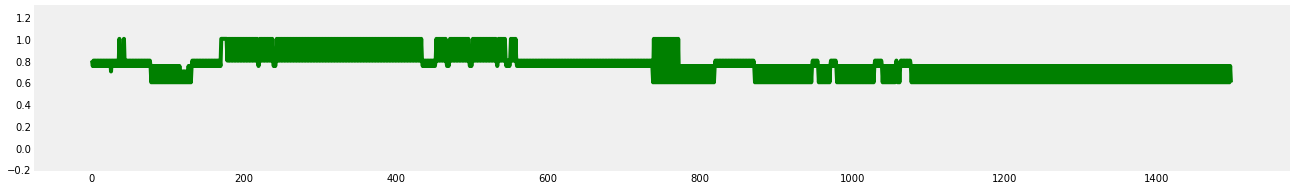

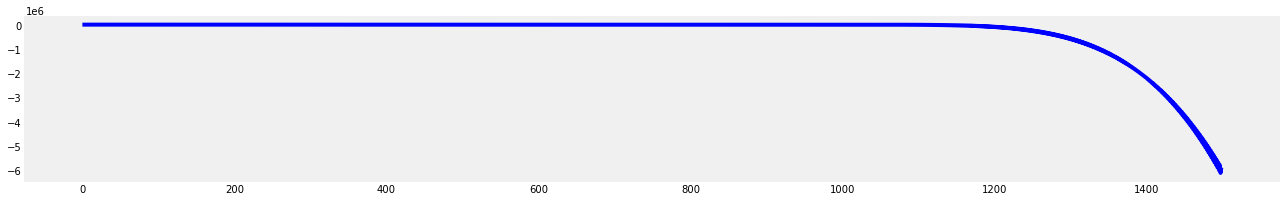

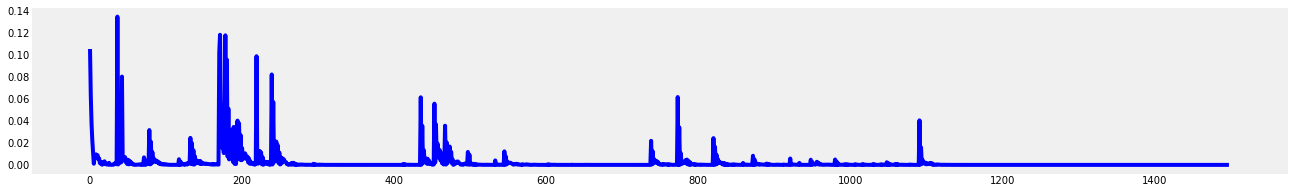

In [17]:
%matplotlib inline

plt.figure(figsize=(20,3))
plt.plot(h_fill,'g-')
plt.ylim(-0.2,1.3)
plt.grid()

plt.figure(figsize=(20,3))
plt.plot(avg_actor_loss_l,'b-')
plt.grid()
plt.show()

plt.figure(figsize=(20,3))
plt.plot(avg_critic_loss_l,'b-')
plt.grid()
plt.show()

In [22]:
for e in range(1, num_episode):
    st=time.time()
    
    if e%2 == 1: boxes_multi,gt_pos = boxes_multi1.copy(), gt_pos1.copy()
    else: boxes_multi,gt_pos = boxes_multi2.copy(), gt_pos2.copy()
    
    env.reset()
    done = False
    step = 0
    
    history, h_load, h_remain_size, h_load_size = [],[],[],[]
    values, prob_l, dones, next_values = [],[],[],[]
    used_boxes, pred_pos = [],[]
    
    boxes_all = np.array(boxes_multi)[0].copy()
    r_boxes = boxes_all.copy()

    while not done:
        state = env.container_s.copy()
        state_h = env.container_h.copy()
        step += 1
        
        k = min(K, len(r_boxes))
        selected = cbn_select_boxes(r_boxes[:n_candidates], k)
        s_order = get_selected_order(selected, k)
        
        num_loaded_c, loading_size_c, loading_pos_c, next_state_c, next_h_c, loaded_mh_c = get_selected_location(s_order, state, state_h, env.height)
        in_state, in_r_boxes, in_loading = raw2input(state_h, len(num_loaded_c), r_boxes, num_max_remain, K, loading_size_c, env.height)
        
        loaded_mh_c = np.array(loaded_mh_c)
        if len(num_loaded_c) == 1:
            prob, action_idx = agent.get_action(in_state,loaded_mh_c, in_r_boxes, in_loading)
            prob_l.append(prob)
            value = agent.get_value(in_state, loaded_mh_c, in_r_boxes, in_loading)
            values.append(value)
        else:
            prob, action_idx = agent.get_action(in_state,loaded_mh_c, in_r_boxes, in_loading)
            value = agent.get_value(in_state, loaded_mh_c, in_r_boxes, in_loading)
            prob_l.append(prob)
            values.append(value)
    
        env.step(next_state_c[action_idx], next_h_c[action_idx])
        num_loaded_box = num_loaded_c[action_idx]
        
        if num_loaded_box != 0:
            new_used_boxes = loading_size_c[action_idx]
            r_boxes = get_remain(new_used_boxes, r_boxes)
        else:
            r_boxes = get_remain(s_order[action_idx], r_boxes)
            
        used_boxes = used_boxes + loading_size_c[action_idx]
        pred_pos = pred_pos + loading_pos_c[action_idx]
        
        if len(r_boxes) == 0 or np.sum(env.container_h != env.height) == 0:
            done = True

        if len(num_loaded_c) != 1 or done:
            dones.append(done)
            history.append(in_state[action_idx])
            h_load.append(loaded_mh_c[action_idx])
            h_remain_size.append(in_r_boxes[action_idx])
            h_load_size.append(in_loading[action_idx])
            
            next_state = next_state_c[action_idx].copy()
            next_state_h = next_h_c[action_idx].copy()
            
            if done:
                in_next_history = next_state_h.reshape((1, env.length, env.breadth, 1))
                loaded_mh_c = np.zeros((1, env.length, env.breadth, 2))
                in_next_remains = np.zeros((1, env.length, env.breadth, num_max_remain))
                in_next_loading = np.zeros((1, env.length, env.breadth, K))
            else:
                k = min(K, len(r_boxes))
                selected = cbn_select_boxes(r_boxes[:n_candidates], k)
                s_order = get_selected_order(selected, k)
                num_loaded_c, loading_size_c, loading_pos_c, next_state_c, next_h_c, loaded_mh_c = get_selected_location(s_order, next_state, next_state_h, env.height)
                in_next_history, in_next_remains, in_next_loading = \
                    raw2input(next_state_h, len(num_loaded_c), r_boxes, num_max_remain,  K, loading_size_c, env.height)
            
            loaded_mh_c = np.array(loaded_mh_c)
            next_value = agent.get_value(in_next_history, loaded_mh_c, in_next_remains, in_next_loading)
            next_values.append(next_value)
                
        if done:
            h_fill.append(env.terminal_reward())
            rewards = terminal_rewards(history, agent.discount_factor, env.terminal_reward()**3)
            
            returns = get_discnt_reward(rewards, values, next_values, dones)
            advantage = get_advantage(returns, values)
            
            probs = np.stack(prob_l, axis=0)
            
            agent.train(history, h_load, h_remain_size, h_load_size, returns, advantage, probs)
            avg_actor_loss_l.append(agent.avg_actor_loss)
            avg_critic_loss_l.append(agent.avg_critic_loss)

    log = "=====episode: {:5d} | ".format(e)
    log += "reward : {:.3f}| ".format(env.terminal_reward())
    log += "actor loss : {:6f} ".format(agent.avg_actor_loss / float(step))
    log += "critic loss : {:6f} ".format(agent.avg_critic_loss / float(step))
    log += "time: {:.3f}".format(time.time()-st)
    print(log)
    
    agent.avg_actor_loss, agent.avg_critic_loss = 0, 0

=====episode:     1 | reward : 0.720| actor loss : 0.038585 critic loss : 0.038687 time: 0.212
=====episode:     2 | reward : 0.750| actor loss : 0.017855 critic loss : 0.017939 time: 0.152
=====episode:     3 | reward : 0.760| actor loss : 0.031499 critic loss : 0.031581 time: 0.130
=====episode:     4 | reward : 0.750| actor loss : 0.009322 critic loss : 0.009415 time: 0.145
=====episode:     5 | reward : 1.000| actor loss : 0.091845 critic loss : 0.091922 time: 0.141
=====episode:     6 | reward : 1.000| actor loss : 0.073852 critic loss : 0.073929 time: 0.169
=====episode:     7 | reward : 1.000| actor loss : 0.067549 critic loss : 0.067629 time: 0.149
=====episode:     8 | reward : 0.750| actor loss : 0.002581 critic loss : 0.002670 time: 0.146
=====episode:     9 | reward : 1.000| actor loss : 0.048490 critic loss : 0.048565 time: 0.157
=====episode:    10 | reward : 0.750| actor loss : 0.004223 critic loss : 0.004318 time: 0.137
=====episode:    11 | reward : 1.000| actor loss :

=====episode:    89 | reward : 0.800| actor loss : -0.000062 critic loss : 0.000114 time: 0.121
=====episode:    90 | reward : 0.750| actor loss : 0.000218 critic loss : 0.000268 time: 0.156
=====episode:    91 | reward : 0.800| actor loss : 0.000005 critic loss : 0.000182 time: 0.125
=====episode:    92 | reward : 0.750| actor loss : 0.000119 critic loss : 0.000167 time: 0.146
=====episode:    93 | reward : 0.800| actor loss : 0.000025 critic loss : 0.000202 time: 0.120
=====episode:    94 | reward : 0.750| actor loss : 0.000092 critic loss : 0.000138 time: 0.160
=====episode:    95 | reward : 0.800| actor loss : -0.000009 critic loss : 0.000168 time: 0.122
=====episode:    96 | reward : 0.750| actor loss : 0.000051 critic loss : 0.000095 time: 0.140
=====episode:    97 | reward : 0.800| actor loss : -0.000072 critic loss : 0.000105 time: 0.118
=====episode:    98 | reward : 0.750| actor loss : 0.000009 critic loss : 0.000052 time: 0.139
=====episode:    99 | reward : 0.800| actor los

=====episode:   175 | reward : 0.800| actor loss : -0.000082 critic loss : 0.000011 time: 0.122
=====episode:   176 | reward : 0.750| actor loss : -0.000121 critic loss : 0.000008 time: 0.148
=====episode:   177 | reward : 0.800| actor loss : -0.000104 critic loss : 0.000013 time: 0.134
=====episode:   178 | reward : 0.750| actor loss : -0.000125 critic loss : 0.000007 time: 0.172
=====episode:   179 | reward : 0.800| actor loss : -0.000108 critic loss : 0.000014 time: 0.137
=====episode:   180 | reward : 0.750| actor loss : -0.000134 critic loss : 0.000003 time: 0.142
=====episode:   181 | reward : 0.800| actor loss : -0.000085 critic loss : 0.000013 time: 0.124
=====episode:   182 | reward : 0.750| actor loss : -0.000113 critic loss : 0.000003 time: 0.150
=====episode:   183 | reward : 0.800| actor loss : -0.000095 critic loss : 0.000011 time: 0.123
=====episode:   184 | reward : 0.750| actor loss : -0.000108 critic loss : 0.000003 time: 0.151
=====episode:   185 | reward : 0.800| ac

=====episode:   261 | reward : 0.720| actor loss : -0.000106 critic loss : 0.000048 time: 0.111
=====episode:   262 | reward : 1.000| actor loss : 0.009709 critic loss : 0.009789 time: 0.123
=====episode:   263 | reward : 0.720| actor loss : 0.000965 critic loss : 0.001123 time: 0.098
=====episode:   264 | reward : 1.000| actor loss : 0.002898 critic loss : 0.002994 time: 0.124
=====episode:   265 | reward : 0.800| actor loss : 0.001502 critic loss : 0.001615 time: 0.120
=====episode:   266 | reward : 1.000| actor loss : 0.000356 critic loss : 0.000457 time: 0.133
=====episode:   267 | reward : 0.800| actor loss : 0.000766 critic loss : 0.000887 time: 0.126
=====episode:   268 | reward : 1.000| actor loss : 0.001339 critic loss : 0.001438 time: 0.141
=====episode:   269 | reward : 0.800| actor loss : 0.000866 critic loss : 0.001000 time: 0.123
=====episode:   270 | reward : 1.000| actor loss : 0.002416 critic loss : 0.002511 time: 0.122
=====episode:   271 | reward : 0.800| actor loss 

=====episode:   347 | reward : 0.600| actor loss : -0.000561 critic loss : 0.000123 time: 0.126
=====episode:   348 | reward : 0.750| actor loss : 0.001278 critic loss : 0.001875 time: 0.129
=====episode:   349 | reward : 0.600| actor loss : -0.000441 critic loss : 0.000328 time: 0.118
=====episode:   350 | reward : 0.750| actor loss : 0.000949 critic loss : 0.001585 time: 0.129
=====episode:   351 | reward : 0.600| actor loss : 0.000095 critic loss : 0.000953 time: 0.119
=====episode:   352 | reward : 0.750| actor loss : 0.001501 critic loss : 0.002177 time: 0.124
=====episode:   353 | reward : 0.600| actor loss : 0.000257 critic loss : 0.001205 time: 0.122
=====episode:   354 | reward : 0.700| actor loss : 0.004301 critic loss : 0.004335 time: 0.100
=====episode:   355 | reward : 0.600| actor loss : -0.000125 critic loss : 0.000904 time: 0.115
=====episode:   356 | reward : 0.700| actor loss : 0.002868 critic loss : 0.002934 time: 0.099
=====episode:   357 | reward : 0.600| actor los

=====episode:   433 | reward : 0.600| actor loss : -0.002798 critic loss : 0.000051 time: 0.124
=====episode:   434 | reward : 0.700| actor loss : -0.000986 critic loss : 0.000080 time: 0.104
=====episode:   435 | reward : 0.600| actor loss : -0.002932 critic loss : 0.000022 time: 0.115
=====episode:   436 | reward : 0.700| actor loss : -0.001174 critic loss : 0.000018 time: 0.109
=====episode:   437 | reward : 0.600| actor loss : -0.003078 critic loss : 0.000009 time: 0.119
=====episode:   438 | reward : 0.700| actor loss : -0.001307 critic loss : 0.000014 time: 0.103
=====episode:   439 | reward : 0.600| actor loss : -0.003185 critic loss : 0.000010 time: 0.115
=====episode:   440 | reward : 0.700| actor loss : -0.001406 critic loss : 0.000043 time: 0.098
=====episode:   441 | reward : 0.600| actor loss : -0.003308 critic loss : 0.000016 time: 0.117
=====episode:   442 | reward : 0.700| actor loss : -0.001545 critic loss : 0.000062 time: 0.096
=====episode:   443 | reward : 0.600| ac

=====episode:   519 | reward : 0.600| actor loss : -0.011717 critic loss : 0.000002 time: 0.124
=====episode:   520 | reward : 0.700| actor loss : -0.011017 critic loss : 0.000000 time: 0.098
=====episode:   521 | reward : 0.600| actor loss : -0.012071 critic loss : 0.000001 time: 0.120
=====episode:   522 | reward : 0.700| actor loss : -0.011430 critic loss : 0.000001 time: 0.102
=====episode:   523 | reward : 0.600| actor loss : -0.012427 critic loss : 0.000000 time: 0.122
=====episode:   524 | reward : 0.700| actor loss : -0.011881 critic loss : 0.000002 time: 0.103
=====episode:   525 | reward : 0.600| actor loss : -0.012810 critic loss : 0.000000 time: 0.117
=====episode:   526 | reward : 0.700| actor loss : -0.012314 critic loss : 0.000002 time: 0.100
=====episode:   527 | reward : 0.600| actor loss : -0.013223 critic loss : 0.000000 time: 0.116
=====episode:   528 | reward : 0.700| actor loss : -0.012808 critic loss : 0.000002 time: 0.099
=====episode:   529 | reward : 0.600| ac

=====episode:   605 | reward : 0.600| actor loss : -0.044003 critic loss : 0.000078 time: 0.115
=====episode:   606 | reward : 0.750| actor loss : -0.016187 critic loss : 0.000338 time: 0.121
=====episode:   607 | reward : 0.600| actor loss : -0.044878 critic loss : 0.000217 time: 0.117
=====episode:   608 | reward : 1.000| actor loss : -0.009614 critic loss : 0.001703 time: 0.119
=====episode:   609 | reward : 0.600| actor loss : -0.045862 critic loss : 0.000261 time: 0.121
=====episode:   610 | reward : 1.000| actor loss : -0.010015 critic loss : 0.001516 time: 0.121
=====episode:   611 | reward : 0.760| actor loss : -0.032472 critic loss : 0.000810 time: 0.098
=====episode:   612 | reward : 1.000| actor loss : -0.011307 critic loss : 0.000476 time: 0.118
=====episode:   613 | reward : 0.760| actor loss : -0.034189 critic loss : 0.000078 time: 0.099
=====episode:   614 | reward : 1.000| actor loss : -0.012023 critic loss : 0.000083 time: 0.125
=====episode:   615 | reward : 0.760| ac

=====episode:   691 | reward : 0.760| actor loss : -0.068124 critic loss : 0.000013 time: 0.105
=====episode:   692 | reward : 1.000| actor loss : -0.019988 critic loss : 0.001110 time: 0.121
=====episode:   693 | reward : 0.760| actor loss : -0.068981 critic loss : 0.000175 time: 0.098
=====episode:   694 | reward : 1.000| actor loss : -0.020876 critic loss : 0.000439 time: 0.129
=====episode:   695 | reward : 0.760| actor loss : -0.069803 critic loss : 0.000329 time: 0.105
=====episode:   696 | reward : 1.000| actor loss : -0.021153 critic loss : 0.000362 time: 0.122
=====episode:   697 | reward : 0.760| actor loss : -0.070870 critic loss : 0.000209 time: 0.104
=====episode:   698 | reward : 1.000| actor loss : -0.019480 critic loss : 0.002223 time: 0.125
=====episode:   699 | reward : 0.760| actor loss : -0.071991 critic loss : 0.000010 time: 0.104
=====episode:   700 | reward : 1.000| actor loss : -0.020544 critic loss : 0.001341 time: 0.122
=====episode:   701 | reward : 0.760| ac

=====episode:   777 | reward : 0.600| actor loss : -0.158832 critic loss : 0.000002 time: 0.117
=====episode:   778 | reward : 1.000| actor loss : -0.038566 critic loss : 0.000024 time: 0.124
=====episode:   779 | reward : 0.600| actor loss : -0.162154 critic loss : 0.000001 time: 0.120
=====episode:   780 | reward : 1.000| actor loss : -0.039536 critic loss : 0.000018 time: 0.132
=====episode:   781 | reward : 0.600| actor loss : -0.165614 critic loss : 0.000000 time: 0.137
=====episode:   782 | reward : 1.000| actor loss : -0.040570 critic loss : 0.000007 time: 0.139
=====episode:   783 | reward : 0.600| actor loss : -0.169283 critic loss : 0.000000 time: 0.151
=====episode:   784 | reward : 1.000| actor loss : -0.041672 critic loss : 0.000009 time: 0.124
=====episode:   785 | reward : 0.600| actor loss : -0.172896 critic loss : 0.000000 time: 0.143
=====episode:   786 | reward : 1.000| actor loss : -0.042642 critic loss : 0.000012 time: 0.190
=====episode:   787 | reward : 0.600| ac

=====episode:   863 | reward : 0.600| actor loss : -0.363784 critic loss : 0.000000 time: 0.132
=====episode:   864 | reward : 1.000| actor loss : -0.098747 critic loss : 0.000000 time: 0.145
=====episode:   865 | reward : 0.600| actor loss : -0.372104 critic loss : 0.000000 time: 0.157
=====episode:   866 | reward : 1.000| actor loss : -0.101426 critic loss : 0.000000 time: 0.138
=====episode:   867 | reward : 0.600| actor loss : -0.380703 critic loss : 0.000000 time: 0.149
=====episode:   868 | reward : 1.000| actor loss : -0.104206 critic loss : 0.000000 time: 0.163
=====episode:   869 | reward : 0.600| actor loss : -0.389583 critic loss : 0.000000 time: 0.151
=====episode:   870 | reward : 1.000| actor loss : -0.107091 critic loss : 0.000000 time: 0.143
=====episode:   871 | reward : 0.600| actor loss : -0.398757 critic loss : 0.000000 time: 0.163
=====episode:   872 | reward : 1.000| actor loss : -0.110082 critic loss : 0.000000 time: 0.164
=====episode:   873 | reward : 0.600| ac

=====episode:   949 | reward : 0.760| actor loss : -0.796470 critic loss : 0.000239 time: 0.130
=====episode:   950 | reward : 1.000| actor loss : -0.361444 critic loss : 0.000284 time: 0.149
=====episode:   951 | reward : 0.760| actor loss : -0.812301 critic loss : 0.000176 time: 0.126
=====episode:   952 | reward : 1.000| actor loss : -0.370362 critic loss : 0.000197 time: 0.155
=====episode:   953 | reward : 0.760| actor loss : -0.828220 critic loss : 0.000104 time: 0.133
=====episode:   954 | reward : 1.000| actor loss : -0.379298 critic loss : 0.000099 time: 0.177
=====episode:   955 | reward : 0.760| actor loss : -0.844293 critic loss : 0.000053 time: 0.129
=====episode:   956 | reward : 1.000| actor loss : -0.388222 critic loss : 0.000059 time: 0.161
=====episode:   957 | reward : 0.760| actor loss : -0.860519 critic loss : 0.000021 time: 0.120
=====episode:   958 | reward : 1.000| actor loss : -0.397200 critic loss : 0.000057 time: 0.150
=====episode:   959 | reward : 0.760| ac

=====episode:  1035 | reward : 0.600| actor loss : -3.513725 critic loss : 0.000003 time: 0.144
=====episode:  1036 | reward : 1.000| actor loss : -1.461438 critic loss : 0.000001 time: 0.143
=====episode:  1037 | reward : 0.600| actor loss : -3.656769 critic loss : 0.000001 time: 0.139
=====episode:  1038 | reward : 1.000| actor loss : -1.528471 critic loss : 0.000001 time: 0.144
=====episode:  1039 | reward : 0.600| actor loss : -3.806894 critic loss : 0.000001 time: 0.132
=====episode:  1040 | reward : 1.000| actor loss : -1.599065 critic loss : 0.000001 time: 0.135
=====episode:  1041 | reward : 0.600| actor loss : -3.964538 critic loss : 0.000000 time: 0.138
=====episode:  1042 | reward : 1.000| actor loss : -1.673442 critic loss : 0.000001 time: 0.143
=====episode:  1043 | reward : 0.600| actor loss : -4.130096 critic loss : 0.000000 time: 0.152
=====episode:  1044 | reward : 1.000| actor loss : -1.751805 critic loss : 0.000000 time: 0.160
=====episode:  1045 | reward : 0.600| ac

=====episode:  1121 | reward : 0.600| actor loss : -24.753510 critic loss : 0.000006 time: 0.147
=====episode:  1122 | reward : 1.000| actor loss : -13.075006 critic loss : 0.000000 time: 0.141
=====episode:  1123 | reward : 0.600| actor loss : -26.118568 critic loss : 0.000004 time: 0.129
=====episode:  1124 | reward : 1.000| actor loss : -13.848869 critic loss : 0.000000 time: 0.130
=====episode:  1125 | reward : 0.600| actor loss : -27.557350 critic loss : 0.000001 time: 0.134
=====episode:  1126 | reward : 1.000| actor loss : -14.667962 critic loss : 0.000000 time: 0.134
=====episode:  1127 | reward : 0.600| actor loss : -29.078303 critic loss : 0.000000 time: 0.141
=====episode:  1128 | reward : 1.000| actor loss : -15.537090 critic loss : 0.000000 time: 0.134
=====episode:  1129 | reward : 0.600| actor loss : -30.687790 critic loss : 0.000000 time: 0.135
=====episode:  1130 | reward : 1.000| actor loss : -16.459969 critic loss : 0.000000 time: 0.127
=====episode:  1131 | reward :

=====episode:  1207 | reward : 0.600| actor loss : -290.438131 critic loss : 0.000602 time: 0.124
=====episode:  1208 | reward : 0.750| actor loss : -217.089569 critic loss : 0.000084 time: 0.117
=====episode:  1209 | reward : 0.600| actor loss : -307.442668 critic loss : 0.000290 time: 0.174
=====episode:  1210 | reward : 0.750| actor loss : -230.393967 critic loss : 0.000030 time: 0.135
=====episode:  1211 | reward : 0.600| actor loss : -325.434408 critic loss : 0.000096 time: 0.154
=====episode:  1212 | reward : 0.750| actor loss : -244.491837 critic loss : 0.000224 time: 0.125
=====episode:  1213 | reward : 0.600| actor loss : -344.465088 critic loss : 0.000078 time: 0.141
=====episode:  1214 | reward : 0.750| actor loss : -259.425537 critic loss : 0.000376 time: 0.117
=====episode:  1215 | reward : 0.600| actor loss : -364.588094 critic loss : 0.000139 time: 0.167
=====episode:  1216 | reward : 0.750| actor loss : -275.238678 critic loss : 0.000360 time: 0.124
=====episode:  1217 

=====episode:  1291 | reward : 0.760| actor loss : -1473.736328 critic loss : 0.000004 time: 0.112
=====episode:  1292 | reward : 1.000| actor loss : -1544.564290 critic loss : 0.000005 time: 0.142
=====episode:  1293 | reward : 0.760| actor loss : -1540.661987 critic loss : 0.000006 time: 0.109
=====episode:  1294 | reward : 1.000| actor loss : -1612.312012 critic loss : 0.000008 time: 0.136
=====episode:  1295 | reward : 0.760| actor loss : -1612.145996 critic loss : 0.000004 time: 0.111
=====episode:  1296 | reward : 1.000| actor loss : -1683.008952 critic loss : 0.000007 time: 0.138
=====episode:  1297 | reward : 0.760| actor loss : -1688.403320 critic loss : 0.000000 time: 0.116
=====episode:  1298 | reward : 1.000| actor loss : -1756.936361 critic loss : 0.000004 time: 0.154
=====episode:  1299 | reward : 0.760| actor loss : -1770.007935 critic loss : 0.000001 time: 0.126
=====episode:  1300 | reward : 1.000| actor loss : -1834.271647 critic loss : 0.000003 time: 0.152
=====episo

=====episode:  1374 | reward : 0.750| actor loss : -11940.821615 critic loss : 0.000001 time: 0.128
=====episode:  1375 | reward : 0.760| actor loss : -12722.921875 critic loss : 0.000001 time: 0.100
=====episode:  1376 | reward : 0.750| actor loss : -12460.097656 critic loss : 0.000001 time: 0.137
=====episode:  1377 | reward : 0.760| actor loss : -13349.790039 critic loss : 0.000001 time: 0.096
=====episode:  1378 | reward : 0.750| actor loss : -12999.098958 critic loss : 0.000001 time: 0.126
=====episode:  1379 | reward : 0.760| actor loss : -14003.552734 critic loss : 0.000000 time: 0.103
=====episode:  1380 | reward : 0.750| actor loss : -13558.450521 critic loss : 0.000001 time: 0.137
=====episode:  1381 | reward : 0.760| actor loss : -14685.338867 critic loss : 0.000000 time: 0.104
=====episode:  1382 | reward : 0.750| actor loss : -14138.826823 critic loss : 0.000001 time: 0.129
=====episode:  1383 | reward : 0.760| actor loss : -15396.138672 critic loss : 0.000000 time: 0.100


=====episode:  1456 | reward : 0.750| actor loss : -57433.942708 critic loss : 0.000000 time: 0.122
=====episode:  1457 | reward : 0.760| actor loss : -73249.156250 critic loss : 0.000000 time: 0.097
=====episode:  1458 | reward : 0.750| actor loss : -59420.546875 critic loss : 0.000000 time: 0.119
=====episode:  1459 | reward : 0.760| actor loss : -76037.156250 critic loss : 0.000000 time: 0.103
=====episode:  1460 | reward : 0.750| actor loss : -61464.010417 critic loss : 0.000000 time: 0.123
=====episode:  1461 | reward : 0.760| actor loss : -78912.718750 critic loss : 0.000000 time: 0.098
=====episode:  1462 | reward : 0.750| actor loss : -63565.546875 critic loss : 0.000000 time: 0.125
=====episode:  1463 | reward : 0.760| actor loss : -81877.906250 critic loss : 0.000000 time: 0.103
=====episode:  1464 | reward : 0.750| actor loss : -65726.432292 critic loss : 0.000000 time: 0.119
=====episode:  1465 | reward : 0.760| actor loss : -84934.867188 critic loss : 0.000000 time: 0.096


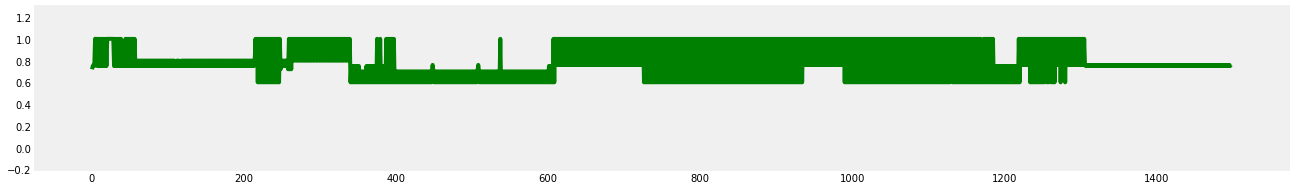

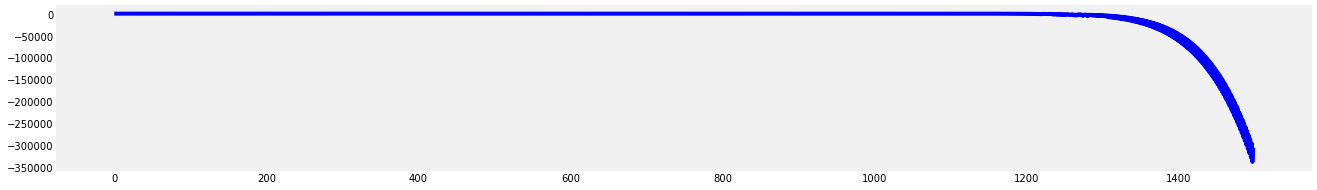

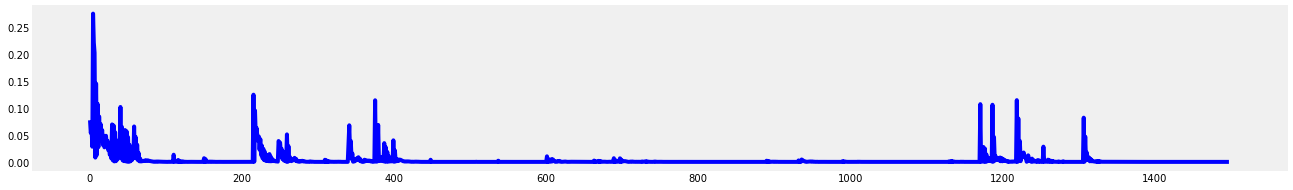

In [24]:
%matplotlib inline

plt.figure(figsize=(20,3))
plt.plot(h_fill,'g-')
plt.ylim(-0.2,1.3)
plt.grid()

plt.figure(figsize=(20,3))
plt.plot(avg_actor_loss_l,'b-')
plt.grid()
plt.show()

plt.figure(figsize=(20,3))
plt.plot(avg_critic_loss_l,'b-')
plt.grid()
plt.show()

특정 횟수 지나면 Loss 매우 커지는 문제 발생 (과적합인듯?)

### List 마다 돌리기?